In [1]:
import os
import torch
import pyprobound
import pyprobound.plotting
from matplotlib import pyplot as plt
from pyprobound.utils import avg_pool1d
import scipy.stats

/Users/lucas/.pyenv/versions/3.11.4/lib/python3.11/site-packages/logomaker/src/validate.py:98: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if matrix_type is 'information':
/Users/lucas/.pyenv/versions/3.11.4/lib/python3.11/site-packages/logomaker/src/validate.py:104: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif matrix_type is 'probability':


In [2]:
alphabet = pyprobound.alphabets.DNA()
dataframe = pyprobound.get_dataframe(
    ["../data/CTCF_ChIP-seq/Control-R1_CTCF-R1.1000000.tsv.gz"]
)
count_table = pyprobound.CountTable(dataframe, alphabet, zero_pad=True)
dataframe_center = pyprobound.get_dataframe(
    ["../data/CTCF_ChIP-seq/Control-R1_CTCF-R1.center.1000000.tsv.gz"]
)
count_table_center = pyprobound.CountTable(
    dataframe_center, alphabet, zero_pad=True
)

In [3]:
def get_data(experiment: pyprobound.Experiment, count_table):
    counts_obs, counts_pred = pyprobound.score(experiment, count_table)
    counts_pred = torch.exp(counts_pred) * counts_obs.sum(dim=1, keepdim=True)
    fold_enr = counts_pred[:, 1] / counts_pred[:, 0]
    sorting = torch.argsort(fold_enr, descending=True)
    counts_pred, counts_obs = counts_pred[sorting], counts_obs[sorting]
    counts_pred = avg_pool1d(counts_pred, 500)
    counts_obs = avg_pool1d(counts_obs, 500)
    x_pred = (
        (counts_pred[:, 1] + (1 / 500)) / (counts_pred[:, 0] + (1 / 500))
    ).float()
    y_obs = (
        (counts_obs[:, 1] + (1 / 500)) / (counts_obs[:, 0] + (1 / 500))
    ).float()
    pearson = scipy.stats.pearsonr(x_pred.log(), y_obs.log()).statistic
    logposbias = torch.exp(
        experiment.rounds[-1]
        .aggregate.contributions[-1]
        .binding.layers[-1]
        .log_posbias.detach()
    ).flatten()
    return x_pred, y_obs, f"$r$={pearson:.2f}", logposbias

In [4]:
nonspecific = pyprobound.layers.NonSpecific(alphabet=alphabet, name="NS")
fragmentation_psams = [
    pyprobound.layers.PSAM(
        alphabet=alphabet,
        kernel_size=10,
        name=f"Fragmentation{i}",
    )
    for i in range(5)
]
ctcf_psam = pyprobound.layers.PSAM(
    alphabet=alphabet,
    kernel_size=18,
    seed=["---CGCCMYCTAGTGG--"],
    name="CTCF",
)

# NS
conv0d = pyprobound.layers.Conv0d.from_nonspecific(nonspecific, count_table)
mode_ns = pyprobound.Mode([conv0d])

# LeftFragmentation
roll_left = pyprobound.layers.Roll.from_spec(
    pyprobound.layers.RollSpec(
        alphabet, direction="left", max_length=10, include_n=True
    ),
    count_table,
)
conv1ds_left = [
    pyprobound.layers.Conv1d.from_psam(
        psam, roll_left, out_channel_indexing=[0]
    )
    for psam in fragmentation_psams
]
modes_left = [
    pyprobound.Mode([roll_left, conv1d_left]) for conv1d_left in conv1ds_left
]

# RightFragmentation
roll_right = pyprobound.layers.Roll.from_spec(
    pyprobound.layers.RollSpec(
        alphabet, direction="right", max_length=10, include_n=True
    ),
    count_table,
)
conv1ds_right = [
    pyprobound.layers.Conv1d.from_psam(
        psam, roll_right, out_channel_indexing=[1]
    )
    for psam in fragmentation_psams
]
modes_right = [
    pyprobound.Mode([roll_right, conv1d_right])
    for conv1d_right in conv1ds_right
]

# CTCF
roll_center = pyprobound.layers.Roll.from_spec(
    pyprobound.layers.RollSpec(alphabet, direction="center", include_n=True),
    count_table,
)
conv1d = pyprobound.layers.Conv1d.from_psam(
    ctcf_psam,
    roll_center,
    train_posbias=True,
    bias_bin=5,
    length_specific_bias=False,
    bias_mode="same",
)
mode_ctcf = pyprobound.Mode([roll_center, conv1d])

# Rounds
round_initial = pyprobound.rounds.InitialRound()
reference_round = round_initial
for mode_left, mode_right in zip(modes_left, modes_right):
    round_left = pyprobound.rounds.BoundUnsaturatedRound.from_binding(
        [mode_ns, mode_left],
        reference_round,
        activity_heuristic=0.1,
        train_depth=False,
    )
    round_right = pyprobound.rounds.BoundUnsaturatedRound.from_binding(
        [mode_ns, mode_right],
        round_left,
        activity_heuristic=0.1,
        train_depth=False,
    )
    reference_round = round_right
round_bound = pyprobound.rounds.BoundUnsaturatedRound.from_binding(
    [mode_ns, mode_ctcf], reference_round, activity_heuristic=0.1
)
experiment = pyprobound.Experiment(
    [round_initial, round_bound],
    counts_per_round=count_table.counts_per_round,
)
model5 = pyprobound.MultiExperimentLoss([experiment], full_loss=True)
model5.reload("CTCF_ChIP-seq_end5.pt")
x_5, y_5, r_5, p_5 = get_data(experiment, count_table)

In [5]:
nonspecific = pyprobound.layers.NonSpecific(alphabet=alphabet, name="NS")
ctcf_psam = pyprobound.layers.PSAM(
    alphabet=alphabet,
    kernel_size=18,
    seed=["---CGCCMYCTAGTGG--"],
    name="CTCF",
)

# NS
conv0d = pyprobound.layers.Conv0d.from_nonspecific(nonspecific, count_table)
mode_ns = pyprobound.Mode([conv0d])

# CTCF
conv1d = pyprobound.layers.Conv1d.from_psam(
    ctcf_psam,
    count_table,
    train_posbias=True,
    bias_bin=5,
    length_specific_bias=False,
    bias_mode="same",
)
mode_ctcf = pyprobound.Mode([conv1d])

# Rounds
round_0 = pyprobound.rounds.InitialRound()
round_1 = pyprobound.rounds.BoundUnsaturatedRound.from_binding(
    [mode_ns, mode_ctcf], round_0, activity_heuristic=0.1
)
experiment = pyprobound.Experiment(
    [round_0, round_1],
    counts_per_round=count_table.counts_per_round,
)
modelC = pyprobound.MultiExperimentLoss([experiment], full_loss=True)
modelC.reload("CTCF_ChIP-seq_center.pt")
x_C, y_C, r_C, p_C = get_data(experiment, count_table_center)

In [6]:
nonspecific = pyprobound.layers.NonSpecific(alphabet=alphabet, name="NS")
ctcf_psam = pyprobound.layers.PSAM(
    alphabet=alphabet,
    kernel_size=18,
    seed=["---CGCCMYCTAGTGG--"],
    name="CTCF",
)

# NS
conv0d = pyprobound.layers.Conv0d.from_nonspecific(nonspecific, count_table)
mode_ns = pyprobound.Mode([conv0d])

# CTCF
roll_center = pyprobound.layers.Roll.from_spec(
    pyprobound.layers.RollSpec(alphabet, direction="center", include_n=True),
    count_table,
)
conv1d = pyprobound.layers.Conv1d.from_psam(
    ctcf_psam,
    roll_center,
    train_posbias=True,
    bias_bin=5,
    length_specific_bias=False,
    bias_mode="same",
)
mode_ctcf = pyprobound.Mode([roll_center, conv1d])

# Rounds
round_0 = pyprobound.rounds.InitialRound()
round_1 = pyprobound.rounds.BoundUnsaturatedRound.from_binding(
    [mode_ns, mode_ctcf], round_0, activity_heuristic=0.1
)
experiment = pyprobound.Experiment(
    [round_0, round_1],
    counts_per_round=count_table.counts_per_round,
)
model0 = pyprobound.MultiExperimentLoss([experiment], full_loss=True)
model0.reload("CTCF_ChIP-seq_end0.pt")
x_0, y_0, r_0, p_0 = get_data(experiment, count_table)

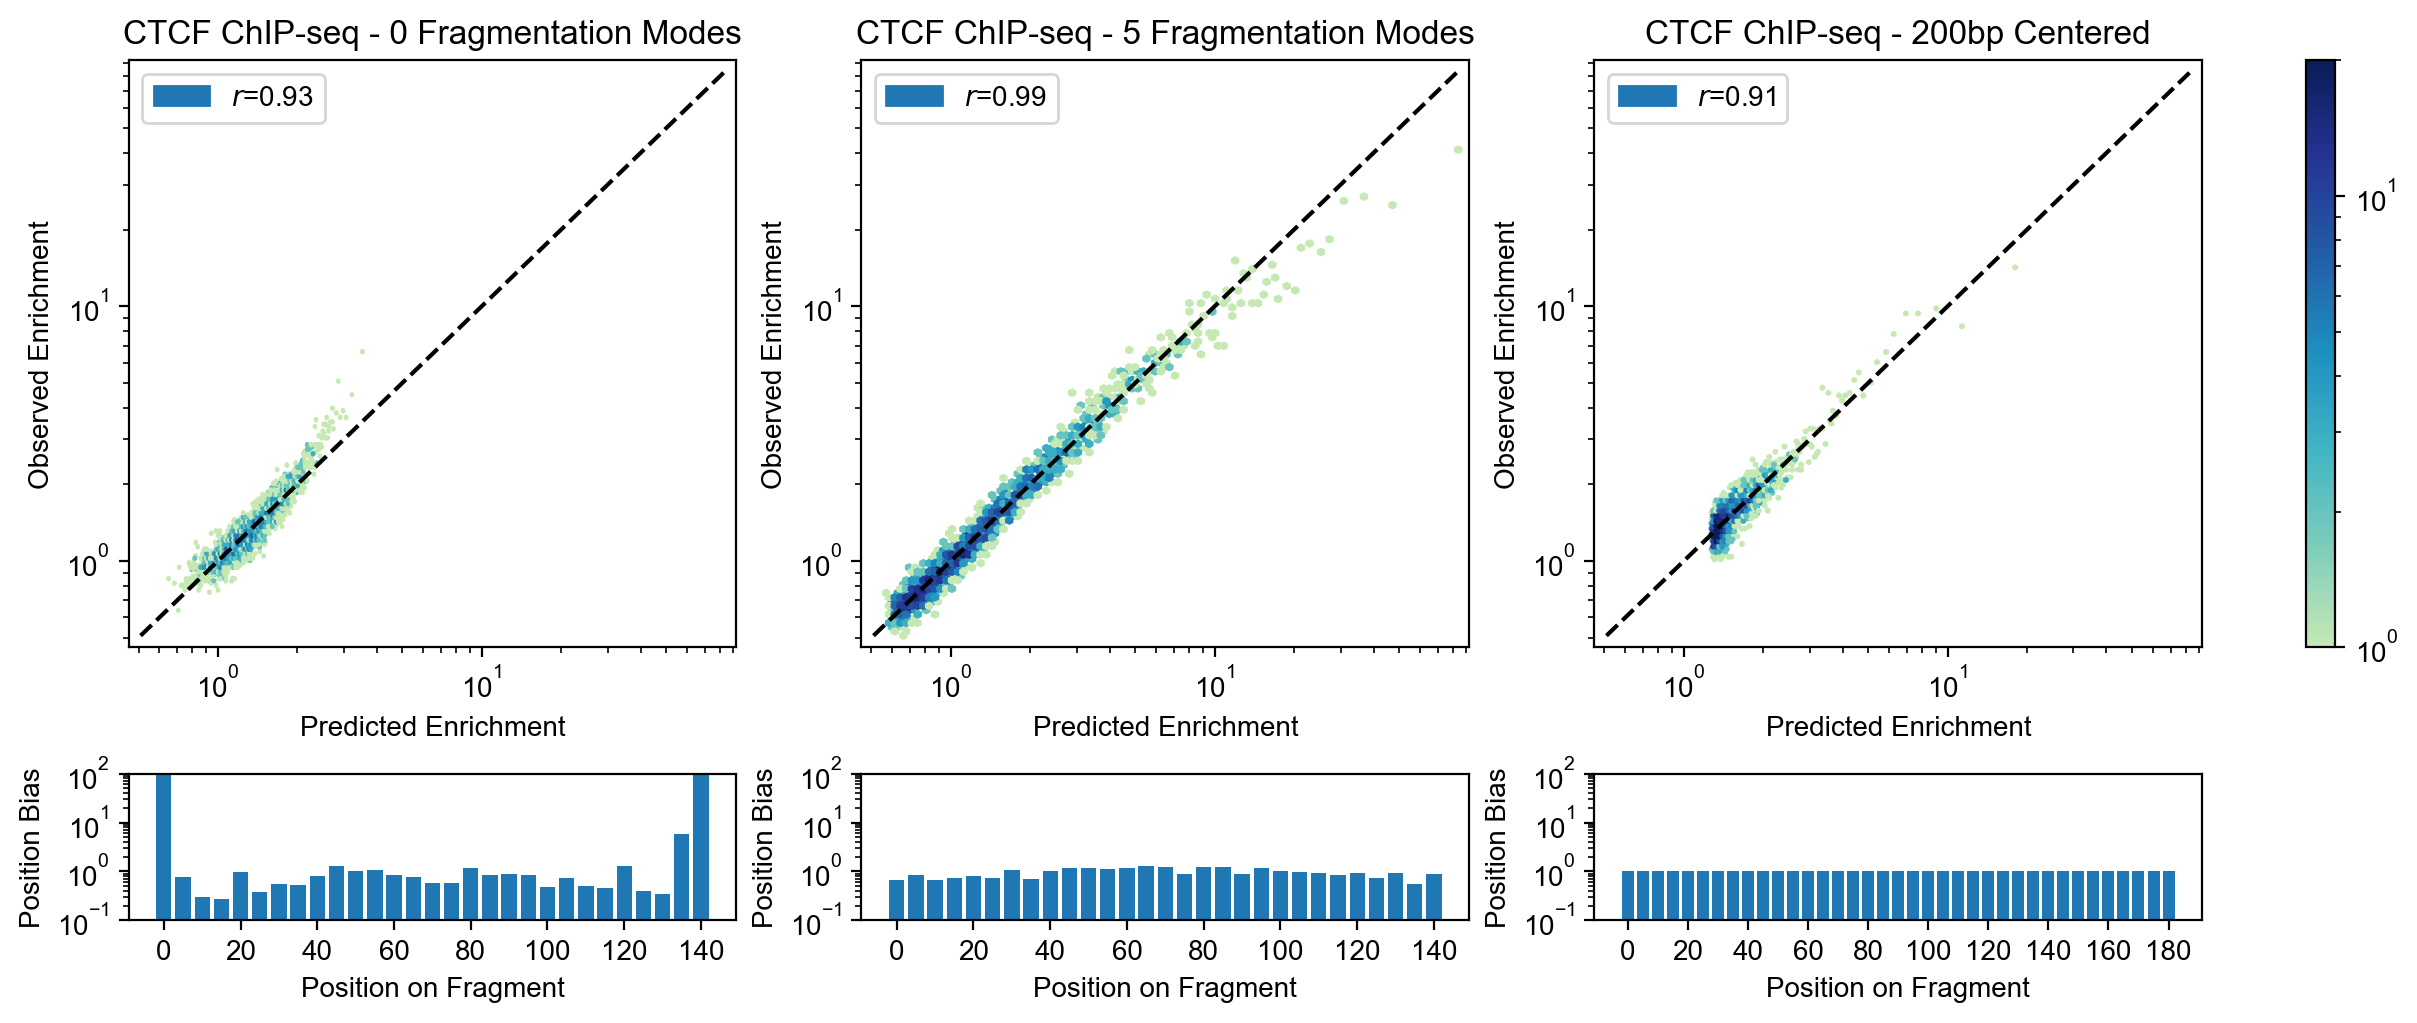

In [16]:
ratio = 4
width = 12
fig, axs = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(12, 5),
    gridspec_kw={"height_ratios": [4, 1]},
    constrained_layout=True,
)
min_range = min(
    x_0.min(), y_0.min(), x_C.min(), y_C.min(), x_5.min(), y_5.min()
)
max_range = max(
    x_0.max(), y_0.max(), x_C.max(), y_C.max(), x_5.max(), y_5.max()
)

for i, (x, y, r, p, name) in enumerate(
    [
        (x_0, y_0, r_0, p_0, "0 Fragmentation Modes"),
        (x_5, y_5, r_5, p_5, "5 Fragmentation Modes"),
        (x_C, y_C, r_C, p_C, "200bp Centered"),
    ]
):
    positions = list(range(len(p)))
    axs[1, i].bar(positions, p)
    axs[1, i].set_xticks(positions[::4], [5 * i for i in positions[::4]])
    axs[1, i].set_yscale("log")
    axs[1, i].set_ylim((1e-1, 1e2))
    axs[1, i].set_xlabel("Position on Fragment")
    axs[0, i].set_title(f"CTCF ChIP-seq - {name}")
    binplot = axs[0, i].hexbin(
        x,
        y,
        cmap=pyprobound.plotting.gnbu_mod,
        label=r,
        bins="log",
        xscale="log",
        yscale="log",
        vmin=1,
        vmax=20,
    )
    axs[0, i].plot([min_range, max_range], [min_range, max_range], "k--")
    axs[0, i].set_xlim(0.9 * min_range, 1.1 * max_range)
    axs[0, i].set_ylim(0.9 * min_range, 1.1 * max_range)
    axs[0, i].legend(loc="upper left")
    axs[0, i].set_xlabel("Predicted Enrichment")
    axs[0, i].set_ylabel("Observed Enrichment")
    axs[1, i].set_ylabel("Position Bias")
fig.colorbar(binplot, ax=[axs[0, 0], axs[0, 1], axs[0, 2]])
plt.savefig("compare_enrichment.png")